In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50, MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import kagglehub

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("techsash/waste-classification-data")

print("Path to dataset files:", path)

100%|██████████| 427M/427M [00:03<00:00, 118MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1


In [3]:
# Définition des chemins
train_path = "/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TRAIN/"
test_path = "/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TEST/"

# Hyperparamètres
img_rows, img_cols = 224, 224
batch_size = 64
n_epochs = 10
input_shape = (img_rows, img_cols, 3)
learning_rate = 0.0001
dropout_rate = 0.5
validation_split = 0.2

In [16]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=validation_split,
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Générateurs d'images
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True,
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


Affichage d'échantillons d'images avec leurs labels :


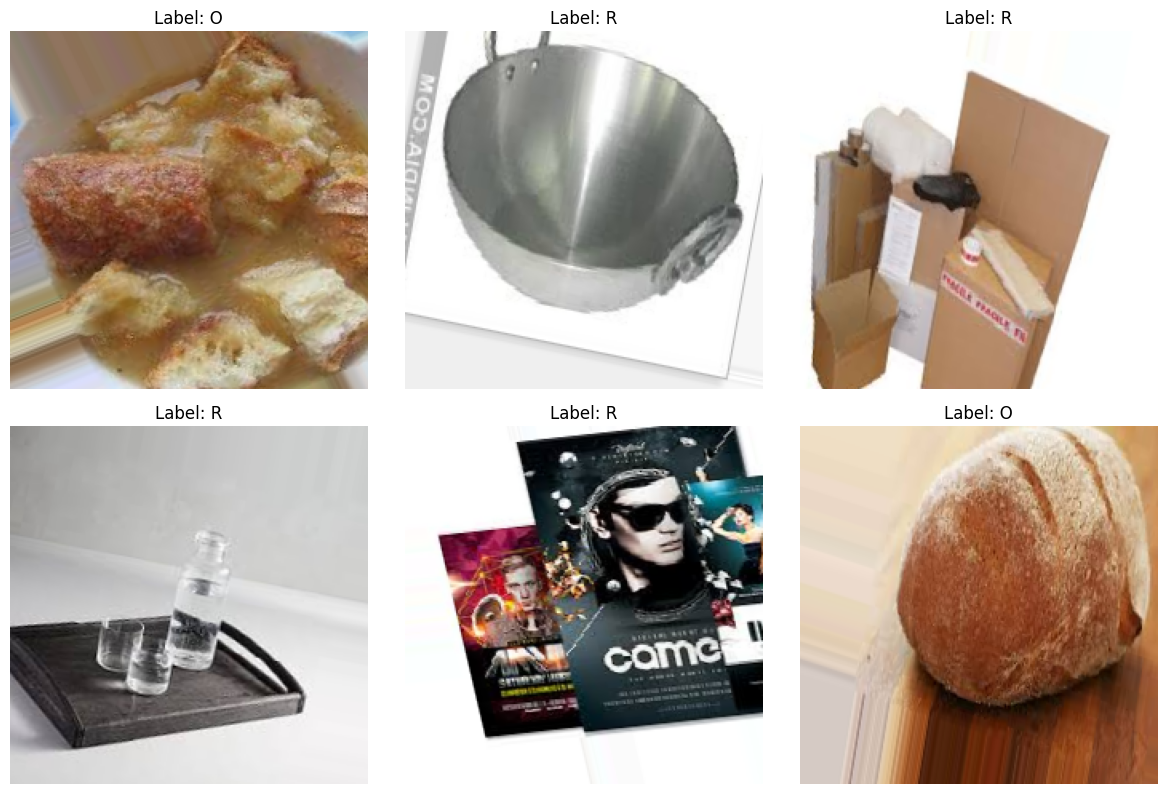

In [15]:
# Fonction pour afficher quelques images avec leurs labels
def show_sample_images(generator, class_labels, num_images=6):

    # Récupérer un batch d'images et de labels depuis le générateur
    images, labels = next(generator)

    # Créer une grille pour afficher les images
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)  # Une grille 3x3
        plt.imshow(images[i])  # Afficher l'image
        # Afficher le label correspondant (O ou R)
        label = class_labels[int(labels[i])]
        plt.title(f"Label: {label}", fontsize=12)
        plt.axis('off')  # Supprimer les axes

    plt.tight_layout()
    plt.show()

# Classes correspondantes : "O" pour organique, "R" pour recyclable
class_labels = ['O', 'R']

# Afficher des images d'entraînement avec leurs labels
print("Affichage d'échantillons d'images avec leurs labels :")
show_sample_images(train_generator, class_labels)


In [6]:
# Fonction pour créer les modèles
def create_model(base_model, model_name):
    base_model.trainable = False  # Geler les couches du modèle pré-entraîné
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print(f"{model_name} modèle créé avec succès.")
    return model

# Créer les modèles
models = {
    "EfficientNetB0": create_model(EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape), "EfficientNetB0"),
    "ResNet50": create_model(ResNet50(weights="imagenet", include_top=False, input_shape=input_shape), "ResNet50"),
    "MobileNetV2": create_model(MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape), "MobileNetV2")
}

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
EfficientNetB0 modèle créé avec succès.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
ResNet50 modèle créé avec succès.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2 modèle créé avec succès.


In [7]:
# Entraîner les modèles
history = {}
results = {}
for model_name, model in models.items():
    print(f"\nEntraînement du modèle : {model_name}")
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

    # Entraînement
    hist = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=n_epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )
    history[model_name] = hist

    # Évaluation sur le jeu de test
    test_loss, test_acc = model.evaluate(test_generator, verbose=1)
    results[model_name] = {"Test Accuracy": test_acc, "Test Loss": test_loss}



Entraînement du modèle : EfficientNetB0
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


283/283 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.5065 - loss: 0.7903 - val_accuracy: 0.5570 - val_loss: 0.6867 - learning_rate: 1.0000e-04
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 320s 932ms/step - accuracy: 0.5155 - loss: 0.7663 - val_accuracy: 0.5570 - val_loss: 0.6865 - learning_rate: 1.0000e-04
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 269s 931ms/step - accuracy: 0.5199 - loss: 0.7555 - val_accuracy: 0.5570 - val_loss: 0.6867 - learning_rate: 1.0000e-04
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 324s 939ms/step - accuracy: 0.5097 - loss: 0.7486 - val_accuracy: 0.5570 - val_loss: 0.6864 - learning_rate: 1.0000e-04
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.5270 - loss: 0.7315
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
283/283 ━━━━━━━━━━━━━━━━━━━━ 269s 932ms/step - accuracy: 0.5270 - loss: 0.7315 - val_accuracy: 0.5570 - val_loss: 0.6868 - learning_rate: 1.0000e-04
Epoch 6/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - accur

NameError: name 'pd' is not defined

In [9]:
import pandas as pd
# Comparer les résultats
results_df = pd.DataFrame(results).T
print("\nRésultats comparatifs :")
print(results_df)


Résultats comparatifs :
                Test Accuracy  Test Loss
EfficientNetB0       0.557501   0.685977
ResNet50             0.714684   0.589692
MobileNetV2          0.889773   0.266906



Résultats pour le modèle : EfficientNetB0


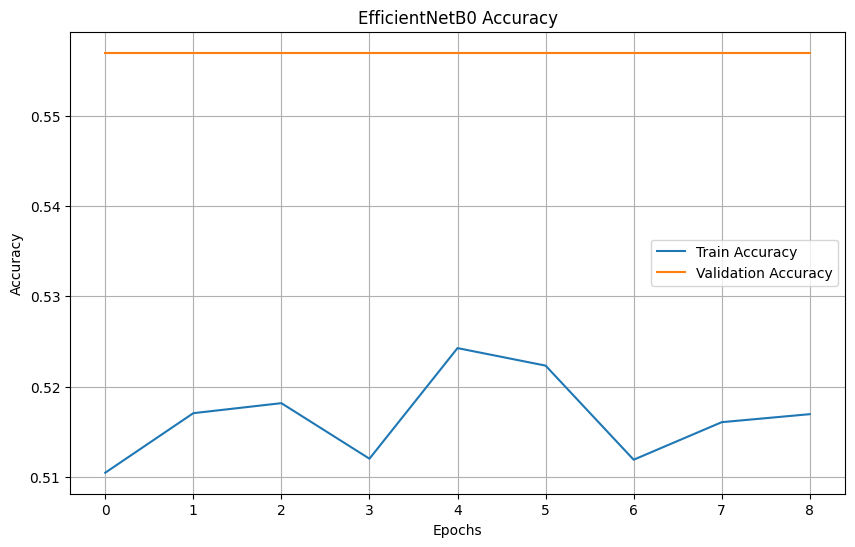

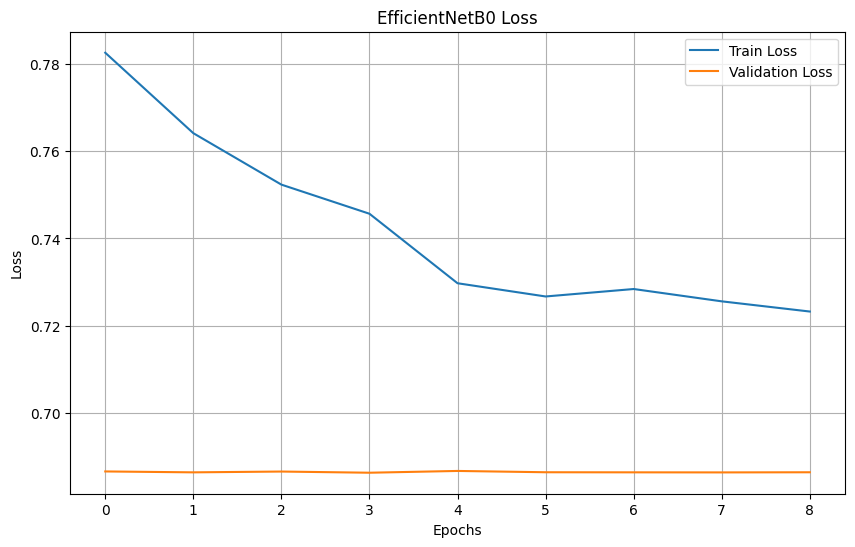

Meilleure précision de validation : 0.5570

Résultats pour le modèle : ResNet50


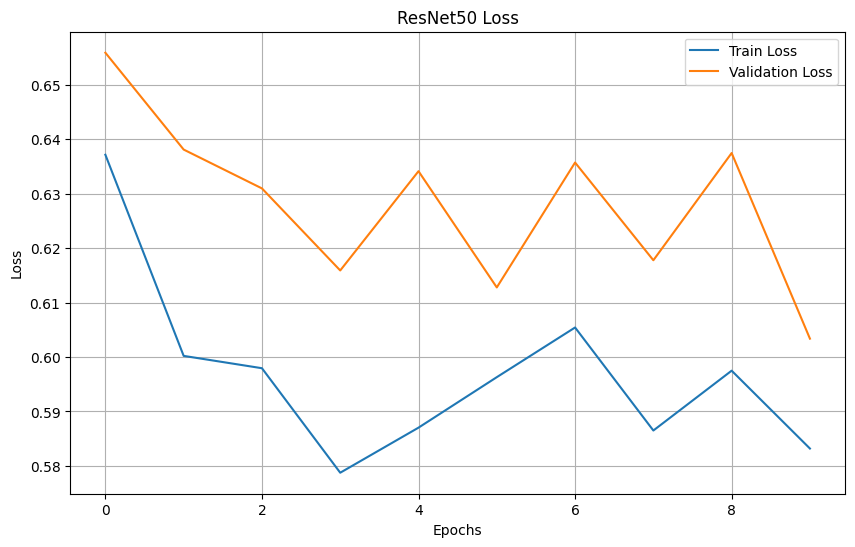

Meilleure précision de validation : 0.7081

Résultats pour le modèle : MobileNetV2


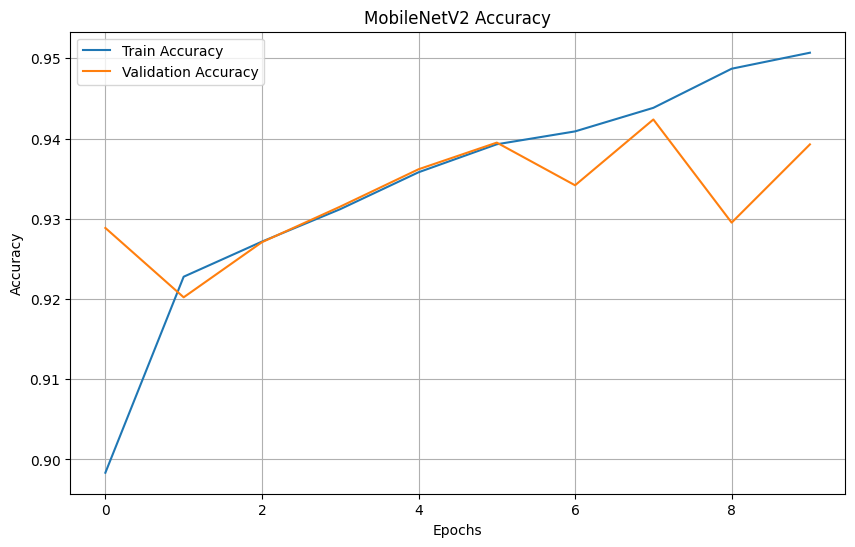

Meilleure précision de validation : 0.9424


In [10]:
# Tracer les courbes d'entraînement
def plot_results(history, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Afficher les courbes pour chaque modèle
for model_name, hist in history.items():
    print(f"\nRésultats pour le modèle : {model_name}")
    plot_results(hist, model_name)
    print(f"Meilleure précision de validation : {max(hist.history['val_accuracy']):.4f}")

In [8]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, roc_auc_score
from google.colab import drive
import os

drive.mount('/content/drive')

model_path = '/content/drive/My Drive/saved_models/ResNet50.h5'

if os.path.exists(model_path):
    model = load_model(model_path)
    print(f"Modèle chargé depuis : {model_path}")
else:
    raise FileNotFoundError(f"Le fichier modèle n'existe pas à l'emplacement : {model_path}")


print("Générateur de test prêt.")

def evaluate_model(generator, model, class_labels):

    generator.reset()
    true_labels = generator.classes

    pred_probs = model.predict(generator)
    pred_labels = (pred_probs > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, target_names=class_labels))

    auc = roc_auc_score(true_labels, pred_probs)
    print(f"AUC-ROC Score: {auc:.4f}")

class_labels = ['O', 'R']
print("\nÉvaluation des métriques pour le modèle chargé :")
evaluate_model(test_generator, model, class_labels)


Mounted at /content/drive


Modèle chargé depuis : /content/drive/My Drive/saved_models/ResNet50.h5
Générateur de test prêt.

Évaluation des métriques pour le modèle chargé :


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 519s 13s/step

Classification Report:
              precision    recall  f1-score   support

           O       0.56      0.73      0.64      1401
           R       0.45      0.28      0.35      1112

    accuracy                           0.53      2513
   macro avg       0.51      0.51      0.49      2513
weighted avg       0.51      0.53      0.51      2513

AUC-ROC Score: 0.5077


In [9]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, roc_auc_score
from google.colab import drive
import os

drive.mount('/content/drive')

model_path = '/content/drive/My Drive/saved_models/EfficientNetB0.h5'

if os.path.exists(model_path):
    model = load_model(model_path)
    print(f"Modèle chargé depuis : {model_path}")
else:
    raise FileNotFoundError(f"Le fichier modèle n'existe pas à l'emplacement : {model_path}")


print("Générateur de test prêt.")

def evaluate_model(generator, model, class_labels):
    generator.reset()

    true_labels = generator.classes

    pred_probs = model.predict(generator)
    pred_labels = (pred_probs > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, target_names=class_labels))

    auc = roc_auc_score(true_labels, pred_probs)
    print(f"AUC-ROC Score: {auc:.4f}")

class_labels = ['O', 'R']
print("\nÉvaluation des métriques pour le modèle chargé :")
evaluate_model(test_generator, model, class_labels)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Modèle chargé depuis : /content/drive/My Drive/saved_models/EfficientNetB0.h5
Générateur de test prêt.

Évaluation des métriques pour le modèle chargé :
40/40 ━━━━━━━━━━━━━━━━━━━━ 230s 6s/step

Classification Report:
              precision    recall  f1-score   support

           O       0.56      1.00      0.72      1401
           R       0.00      0.00      0.00      1112

    accuracy                           0.56      2513
   macro avg       0.28      0.50      0.36      2513
weighted avg       0.31      0.56      0.40      2513

AUC-ROC Score: 0.4872


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_model(generator, model, class_labels):

    generator.reset()

    true_labels = generator.classes

    pred_probs = model.predict(generator, verbose=1)
    pred_labels = (pred_probs > 0.5).astype(int) 

    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, target_names=class_labels))

    auc = roc_auc_score(true_labels, pred_probs)
    print(f"AUC-ROC Score: {auc:.4f}")
    return auc

class_labels = ['O', 'R']

for model_name, model in models.items():
    print(f"\nRapport pour le modèle {model_name} :")
    auc_score = evaluate_model(test_generator, model, class_labels)
    results[model_name]["AUC-ROC"] = auc_score

print("\nRésumé des performances :")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Test Accuracy: {metrics['Test Accuracy']:.4f}")
    print(f"  Test Loss: {metrics['Test Loss']:.4f}")
    print(f"  AUC-ROC: {metrics['AUC-ROC']:.4f}")



Rapport pour le modèle MobileNetV2 :
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step

Classification Report:
              precision    recall  f1-score   support

           O       0.85      0.97      0.91      1401
           R       0.96      0.79      0.86      1112

    accuracy                           0.89      2513
   macro avg       0.90      0.88      0.89      2513
weighted avg       0.90      0.89      0.89      2513

AUC-ROC Score: 0.9760

Résumé des performances :
MobileNetV2:
  Test Accuracy: 0.8902
  Test Loss: 0.2591
  AUC-ROC: 0.9760



Prédictions pour le modèle : EfficientNetB0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


<ipython-input-20-49ac6e123f46>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_labels = [class_labels[int(pred > 0.5)] for pred in predictions]


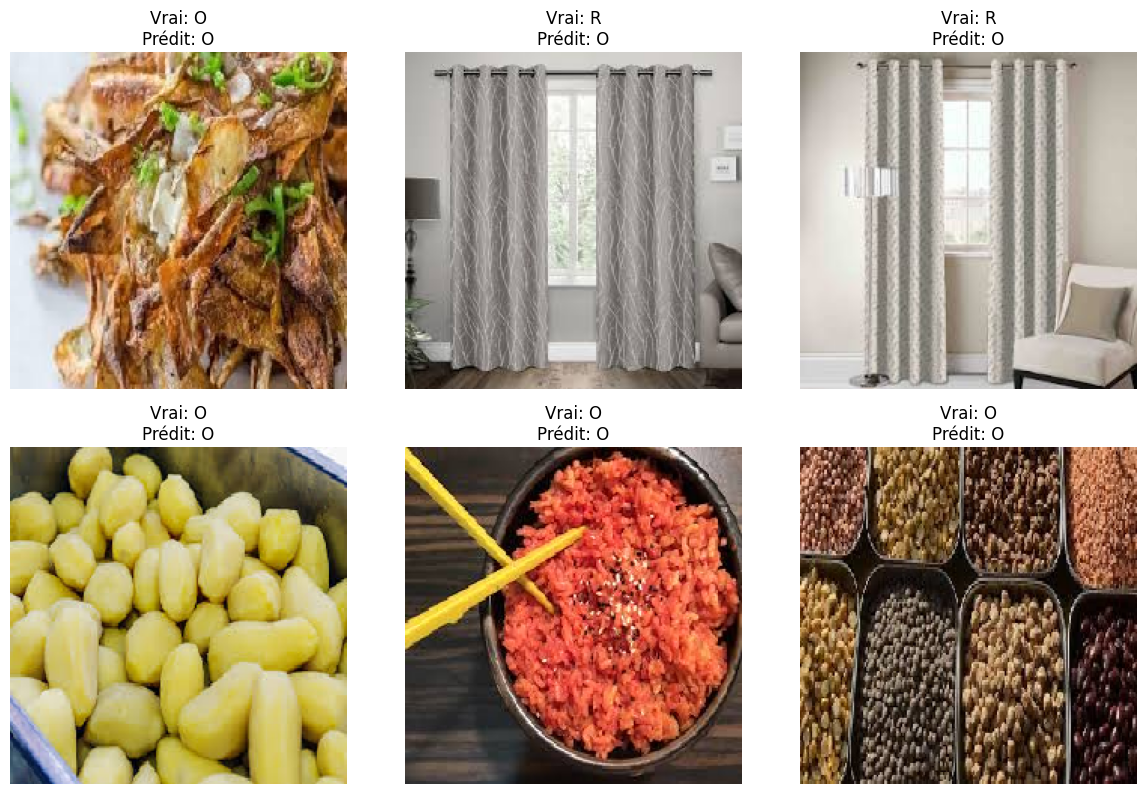


Prédictions pour le modèle : ResNet50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step



Prédictions pour le modèle : MobileNetV2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


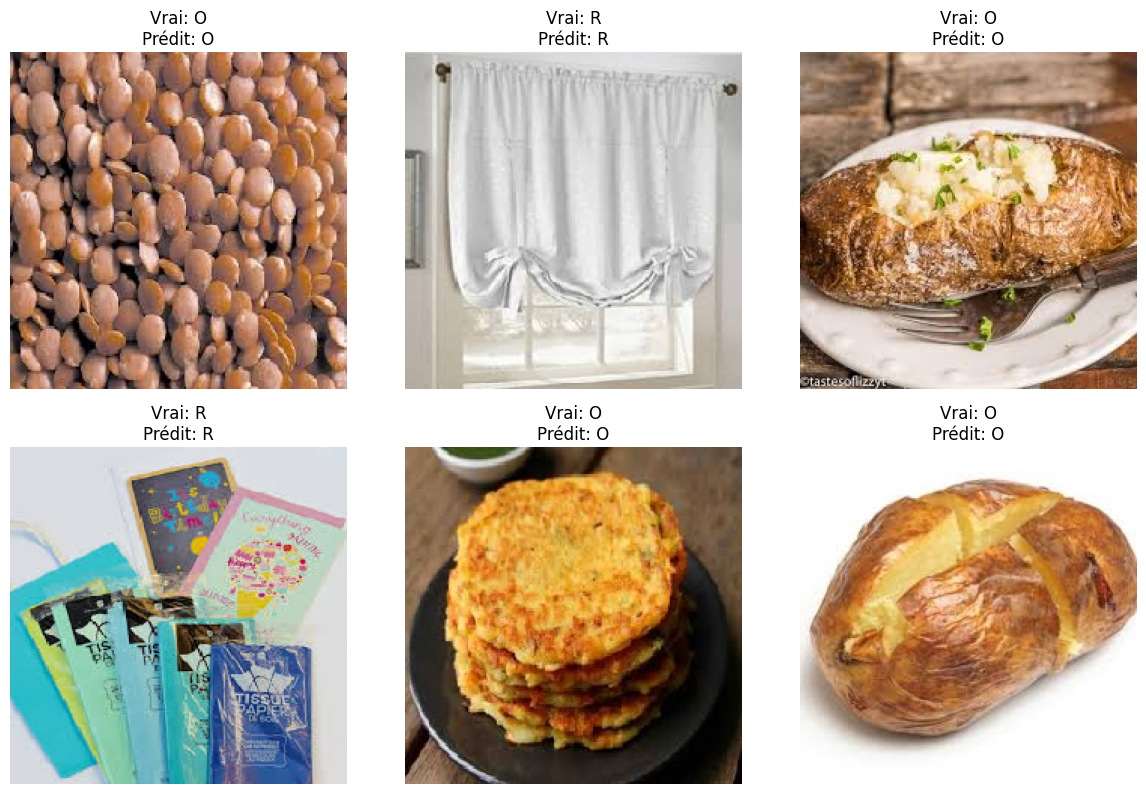

In [20]:
def predict_and_display(generator, model, class_labels, num_images=6):

    images, true_labels = next(generator)

    predictions = model.predict(images)
    predicted_labels = [class_labels[int(pred > 0.5)] for pred in predictions]

    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1) 
        plt.imshow(images[i]) 
        true_label = class_labels[int(true_labels[i])]
        predicted_label = predicted_labels[i]
        plt.title(f"Vrai: {true_label}\nPrédit: {predicted_label}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

for model_name, model in models.items():
    print(f"\nPrédictions pour le modèle : {model_name}")
    predict_and_display(test_generator, model, class_labels, num_images=6)
